In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import ast

# Behavioral Analysis — Delsac Task  

## 1. Dataset Overview  
- **Task design**: The *Delsac* task combines a delayed-saccade spatial working memory task with mapping of color/direction tuning.  
  - Sequence per trial: color/motion pulses (0.96–1.2s) → fixation delay (0.5s) → target presentation (0.1s) → working memory delay (0.7s) → saccade to remembered target.  
- **Data sources**:  
  - Neural dataset: 1 session 154 trials.
  - Behavioral dataset: 2 sessions of eye-tracking data, 6001 samples × 4 channels × 1307 trials per session. Channels: X position, Y position, pupil size, photodiode. (only session *100725* aligned to neural data). 
- **Aligned dataset**: 154 trials aligned to neural data → dropped NaNs → 141 trials remain for analysis.  

---

## 2. Preprocessing Steps  
1. **Trial selection**  
   - Extracted trials from behavioral recordings that matched neural data trials.  

2. **Time–index mapping**  
   - Relative behavioral event times (e.g., fixation onset, target onset, response time) converted into eye-tracker sample indices using  
    [
      $ i = \text{round}\big((t - t_{\text{start}})\cdot f_s\big) = \text{round}\big((t+2.5)\cdot 1000\big) $
    ]
     with $ ( f_s = 1000\ \text{Hz} ) $.  (6001 samples per trial, relative time from stimulus onset = 0 [-2.5, 3.5] seconds)

3. **Eye position extraction**  
   - Eye positions (X, Y) stored in raw tracker units (not DVA).  
   - Fixation and saccade windows defined by event markers.  
   - Computed distance from fixation point (0,0) during fixation windows to verify calibration and fixation quality.  

4. **Target location parsing**  
   - Original target positions encoded as `(eccentricity, angle)` in polar coordinates.  
   - Converted to Cartesian target coordinates in DVA (`targX`, `targY`).  
   - Also mapped to eye tracker units (so analysis is consistent with raw gaze data).  

5. **Response location extraction**  
   - Defined response endpoint as the mean gaze position during the response window.  
   - Converted response endpoints to polar form (`respEcc`, `respAng`) for comparison with target location.  

6. **Derived variables**  
   - **Memory delay**:  
     \[
     $ \text{delay} = \text{responseTime} - \text{targetOff} $ 
     \]  
   - **Error**:  
     \[
     $ \text{err} = \text{curr} - \text{resp} $
     \]  
   - **Previous–current difference**:  
     \[
     $ \theta_d = |\,(\text{curr} - \text{prev})\,|_{\text{circ}} $
     \]  
     circularly wrapped to [0°,180°].  

---

## 3. Behavioral Analyses  

### A. Error distribution  
- Histogram of `err` shows Gaussian-like spread around zero.  
- Confirms calibration and correct execution of saccades on average.  

### B. Memory delay effect  
- Scatter of `err` vs. `delay`: error variability increases with longer delays.  
- Quantified by plotting **std(error)** as function of delay, with linear regression fit.  
- Consistent with working memory degradation over time.  

### C. Sequential bias (attraction/repulsion)  
- Analyzed relationship between error and relative location of previous trial (`theta_d`).  
- Grouped trials into bins of `theta_d` (e.g. 0–30°, 30–60° …).  
- Computed mean error per bin.  
- Found systematic biases depending on whether current target was near to (attraction) or far from (repulsion) previous trial.  



In [2]:
mat_data1 = scipy.io.loadmat('sample data lubna/wetransfer_100725-mat_2025-07-03_1204/100725.mat')

In [3]:
df_idx = pd.read_csv("sample data lubna/df_idx.csv")
df_idx.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   trial             141 non-null    int64  
 1   correct           141 non-null    int64  
 2   targetPos         141 non-null    object 
 3   trialStart        141 non-null    float64
 4   fixptOn           141 non-null    float64
 5   fixationTime      141 non-null    float64
 6   fixptOn2          141 non-null    float64
 7   stimOn            141 non-null    int64  
 8   stimOff           141 non-null    float64
 9   targetOn          141 non-null    float64
 10  targetOff         141 non-null    float64
 11  fixptOff          141 non-null    float64
 12  responseTime      141 non-null    float64
 13  responseDone      141 non-null    float64
 14  trialStart_idx    141 non-null    float64
 15  fixptOn_idx       141 non-null    float64
 16  fixationTime_idx  141 non-null    float64
 1

In [4]:
def inspect_mat(mat_data, name="MAT"):
    print(f"\n{name} Keys:", mat_data.keys())
    for key in mat_data:
        if not key.startswith('__'):
            value = mat_data[key]
            print(f"\nKey: {key}")
            print("Type:", type(value))
            if hasattr(value, 'shape'):
                print("Shape:", value.shape)

inspect_mat(mat_data1, "MAT 1")



MAT 1 Keys: dict_keys(['__header__', '__version__', '__globals__', 'ain', 'ainSchema'])

Key: ain
Type: <class 'numpy.ndarray'>
Shape: (6001, 4, 1307)

Key: ainSchema
Type: <class 'numpy.ndarray'>
Shape: (1, 1)


In [5]:
mat_data1['ainSchema']

array([[(array(['Auxiliary AnalogIn (AIN) data'], dtype='<U29'), array(['amplitude'], dtype='<U9'), array(['raw'], dtype='<U3'), array([[array(['load from /millerdata/data/common/Markus_data/mocol/rec/100725/data/delsac-mocol_paula_100725_fro-par_01.plx'],
                      dtype='<U108')                                                                                                   ,
                array(['interp'], dtype='<U6'),
                array(['resample(1000)'], dtype='<U14'),
                array(['mask'], dtype='<U4'),
                array(['trialParse'], dtype='<U10'),
                array(['trialTimeRef'], dtype='<U12')]], dtype=object), array([[array(['time'], dtype='<U4'), array(['channel'], dtype='<U7'),
                array(['trial'], dtype='<U5')]], dtype=object), array([[array([[-2.5  , -2.499, -2.498, ...,  3.498,  3.499,  3.5  ]]),
                array([[array(['100725.eyePosX'], dtype='<U14'),
                        array(['100725.eyePosY'], dtype='<

In [6]:
rec = mat_data1["ainSchema"][0, 0]

ain = mat_data1["ain"]               # (time, channel, trial)
ntrials = ain.shape[2]

def peel(x):
    """Unwrap array([[obj]], dtype=object) -> obj until not a size-1 object array."""
    while isinstance(x, np.ndarray) and x.dtype == object and x.size == 1:
        x = x.reshape(-1)[0]
    return x

def walk(obj):
    """Yield leaves from a nested object/list/array tree (after peeling)."""
    obj = peel(obj)
    if isinstance(obj, np.ndarray) and obj.dtype == object:
        for y in obj.ravel():
            yield from walk(y)
    elif isinstance(obj, (list, tuple)):
        for y in obj:
            yield from walk(y)
    else:
        yield obj

def get_trial_nums(index_field, expected_len):
    idx = peel(index_field)
    # try the common layout first: [time, channels, trials]
    try:
        cand = peel(idx)[2]
        arr = np.asarray(peel(cand)).astype(int).ravel()
        if arr.size == expected_len:
            return arr
    except Exception:
        pass
    # fallback: search for an integer array of the right length
    for leaf in walk(idx):
        if isinstance(leaf, np.ndarray) and leaf.dtype.kind in "iu":
            arr = np.asarray(leaf).astype(int).ravel()
            if arr.size == expected_len:
                return arr
    raise ValueError("Couldn't find trial numbers in ainSchema.index")

trial_nums = get_trial_nums(rec["index"], ntrials)   # shape (ntrials,)

trial_ids = np.array([  3,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  30,  31,  32,
        33,  34,  37,  38,  39,  40,  41,  42,  43,  44,  46,  48,  50,
        53,  54,  55,  56,  57,  58,  60,  61,  62,  63,  64,  65,  66,
        68,  72,  73,  74,  75,  78,  79,  80,  82,  83,  84,  87,  88,
        89,  92,  94,  97, 100, 101, 103, 104, 105, 106, 107, 108, 112,
       113, 116, 117, 119, 120, 121, 122, 126, 127, 128, 131, 132, 133,
       135, 137, 138, 141, 142, 143, 147, 148, 149, 150, 152, 154, 155,
       156, 158, 160, 162, 163, 164, 165, 167, 168, 169, 170, 171, 172,
       173, 174, 180, 181, 183, 184, 188, 190, 192, 193, 196, 197, 200,
       202, 204, 205, 207, 208, 215, 216, 217, 219, 224, 226], dtype=int)

lookup = {t: i for i, t in enumerate(trial_nums)}
pos = [lookup[t] for t in trial_ids if t in lookup]  # positions along ain's 3rd axis

eye_sel = ain[:, :, pos]   # (6001, 4, N_selected)
eye_sel.shape

(6001, 4, 141)

In [7]:
# Target polar (dva) → Cartesian (dva)

def parse_target_pos(val):
    if isinstance(val, (tuple, list, np.ndarray)):
        if len(val) >= 2:
            try:
                return float(val[0]), float(val[1])
            except Exception:
                pass

    if isinstance(val, str):
        s = val.strip()

        # 1) Remove numpy scalar wrappers like np.uint16(6), np.int16(180), etc.
        #    Keep just the inner numeric literal.
        s = re.sub(r"np\.\w+\(\s*([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)\s*\)", r"\1", s)

        # 2) Remove array wrappers like array([...]) or np.array([...])
        s = re.sub(r"(?:np\.)?array\(\s*(.*?)\s*\)", r"\1", s)

        # At this point, strings like "(np.uint16(6), np.uint16(180))"
        # become "(6, 180)" which ast.literal_eval can parse safely.
        try:
            obj = ast.literal_eval(s)
            if isinstance(obj, (tuple, list)) and len(obj) >= 2:
                return float(obj[0]), float(obj[1])
        except Exception:
            # Fall back to a stricter number extractor that *avoids* letters before the number
            nums = re.findall(r"(?<![A-Za-z])[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", s)
            if len(nums) >= 2:
                return float(nums[0]), float(nums[1])

    return (np.nan, np.nan)

def angle_norm_deg(a):
    # normalize to (-180, 180]
    a = (a + 180.0) % 360.0 - 180.0
    if a == -180.0:
        a = 180.0
    return a

# Re-parse and overwrite the columns
polars = df_idx["targetPos"].apply(parse_target_pos)
df_idx[["targEcc", "targAng"]] = pd.DataFrame(polars.tolist(), index=df_idx.index)

# Optional: normalize angles so 180 and -180 are consistent
df_idx["targAng"] = df_idx["targAng"].apply(angle_norm_deg)

# Polar → Cartesian (dva) with 0°=right, +90°=up
rad = np.deg2rad(df_idx["targAng"])
df_idx["targX"] = df_idx["targEcc"] * np.cos(rad)
df_idx["targY"] = df_idx["targEcc"] * np.sin(rad)



In [8]:
df_idx[["targetPos", "targEcc", "targAng", "targX", "targY"]].head()
df_idx[["targEcc", "targAng"]]


,targEcc,targAng
0,6.0,180.0
1,6.0,-60.0
2,6.0,0.0
3,6.0,-120.0
4,6.0,-60.0
...,...,...
136,6.0,-60.0
137,6.0,120.0
138,6.0,120.0
139,6.0,0.0


In [9]:
n_samples, n_ch, n_trials = eye_sel.shape
assert n_trials == len(df_idx)

# helper: clamp index into [0, n_samples)
def _clip_idx(i):
    return int(max(0, min(n_samples-1, round(i))))

# choose a small averaging window around responseDone to denoise endpoint
halfwin = 10  # samples; adjust (e.g., 10 @ 1 kHz ≈ 10 ms)

endX = np.full(n_trials, np.nan, float)
endY = np.full(n_trials, np.nan, float)
endErr = np.full(n_trials, np.nan, float)

for i in range(n_trials):
    t_done = df_idx.at[i, "responseDone_idx"]
    if np.isnan(t_done):
        continue
    c = _clip_idx(t_done)
    s = max(0, c - halfwin)
    e = min(n_samples, c + halfwin + 1)

    # raw endpoint (tracker units)
    x = eye_sel[s:e, 0, i]
    y = eye_sel[s:e, 1, i]
    if x.size == 0:
        continue
    endX[i] = float(np.nanmean(x))
    endY[i] = float(np.nanmean(y))

# averaged saccade endpoints in tracker units
df_idx["endX_raw"] = endX
df_idx["endY_raw"] = endY

pre_go_win = 25  # samples (~25 ms)
baseX = np.full(n_trials, np.nan, float)
baseY = np.full(n_trials, np.nan, float)

for i in range(n_trials):
    t_go = df_idx.at[i, "fixptOff_idx"]
    if np.isnan(t_go):
        continue
    e = _clip_idx(t_go)
    s = max(0, e - pre_go_win)
    bx = eye_sel[s:e, 0, i]
    by = eye_sel[s:e, 1, i]
    if bx.size == 0:
        continue
    baseX[i] = float(np.nanmean(bx))
    baseY[i] = float(np.nanmean(by))
    
# averaged fixation baseline in tracker units
df_idx["fixBaseX_raw"] = baseX
df_idx["fixBaseY_raw"] = baseY



In [10]:
df_idx

,trial,correct,targetPos,trialStart,fixptOn,fixationTime,fixptOn2,stimOn,stimOff,targetOn,...,responseTime_idx,responseDone_idx,targEcc,targAng,targX,targY,endX_raw,endY_raw,fixBaseX_raw,fixBaseY_raw
0,3,1,"(np.uint16(6), np.uint16(180))",-1.197050,-1.040025,-0.705825,-0.500025,0,1.199925,1.699925,...,5242.0,5250.0,6.0,180.0,-6.0,7.347881e-16,-2152.428571,-15311.428571,-5007.72,-15099.16
1,6,1,"(np.uint16(6), np.uint16(300))",-1.054975,-0.890025,-0.705525,-0.500050,0,1.199925,1.699950,...,5258.0,5267.0,6.0,-60.0,3.0,-5.196152e+00,-6841.238095,-13387.857143,-5094.92,-14996.80
2,7,1,"(np.uint16(6), np.uint16(0))",-1.310175,-1.139975,-0.705050,-0.500000,0,1.199925,1.699925,...,5175.0,5183.0,6.0,0.0,6.0,0.000000e+00,-7812.285714,-14835.523810,-4941.64,-14994.72
3,8,1,"(np.uint16(6), np.uint16(240))",-1.181400,-1.020025,-0.707400,-0.500000,0,1.199925,1.699900,...,5301.0,5309.0,6.0,-120.0,-3.0,-5.196152e+00,-3710.809524,-13327.761905,-5069.48,-15079.68
4,9,1,"(np.uint16(6), np.uint16(300))",-1.212625,-1.050050,-0.709300,-0.500025,0,1.199975,1.699975,...,5311.0,5323.0,6.0,-60.0,3.0,-5.196152e+00,-6928.761905,-13329.523810,-4975.84,-15087.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,216,1,"(np.uint16(6), np.uint16(300))",-1.140925,-0.980025,-0.712150,-0.500050,0,1.199900,1.699925,...,5287.0,5296.0,6.0,-60.0,3.0,-5.196152e+00,-6696.238095,-13132.285714,-4926.36,-15285.08
137,217,1,"(np.uint16(6), np.uint16(120))",-1.317325,-1.150050,-0.706450,-0.500025,0,1.199950,1.699950,...,5225.0,5234.0,6.0,120.0,-3.0,5.196152e+00,-3625.476190,-16934.142857,-4951.48,-15174.88
138,219,1,"(np.uint16(6), np.uint16(120))",-1.301000,-1.140000,-1.024050,-0.500000,0,1.199975,1.699975,...,5244.0,5252.0,6.0,120.0,-3.0,5.196152e+00,-3644.476190,-17051.904762,-4978.92,-15297.84
139,224,1,"(np.uint16(6), np.uint16(0))",-1.405625,-1.240000,-0.703725,-0.500000,0,1.199950,1.699950,...,5244.0,5256.0,6.0,0.0,6.0,0.000000e+00,-8174.476190,-15227.619048,-4918.60,-15270.52


In [11]:
# --- 1) Gather training data on correct trials with all needed fields present
needed = ["correct","targX","targY","endX_raw","endY_raw","fixBaseX_raw","fixBaseY_raw"]
good = (df_idx["correct"] == 1) & df_idx[needed].notna().all(axis=1)

T = df_idx.loc[good, ["targX","targY"]].to_numpy(float)                # (N x 2) in dva
R = df_idx.loc[good, ["endX_raw","endY_raw"]].to_numpy(float)          # (N x 2) raw
B = df_idx.loc[good, ["fixBaseX_raw","fixBaseY_raw"]].to_numpy(float)  # (N x 2) raw baseline

# Work in baseline-relative space to absorb offsets/drift
R_rel = R - B  # (N x 2)

# --- 2) Fit a 2x2 linear mapping: R_rel ≈ T @ A   (least squares)
# A has shape (2 x 2): maps dva -> raw units
A, *_ = np.linalg.lstsq(T, R_rel, rcond=None)  # returns (2 x 2)

# --- 3) Apply mapping to ALL trials to get target predictions in raw units
T_all = df_idx[["targX","targY"]].to_numpy(float)
B_all = df_idx[["fixBaseX_raw","fixBaseY_raw"]].to_numpy(float)

# If any rows have NaNs in T_all or B_all, predictions become NaN automatically
R_pred_rel = T_all @ A                  # (N x 2) predicted relative-to-baseline raw
R_pred_abs = B_all + R_pred_rel         # add each trial's baseline back

df_idx["targX_raw_pred"] = R_pred_abs[:,0]
df_idx["targY_raw_pred"] = R_pred_abs[:,1]

# --- 4) Endpoint error in raw units (distance between actual endpoint and predicted target)
end_xy = df_idx[["endX_raw","endY_raw"]].to_numpy(float)
err = np.hypot(end_xy[:,0] - R_pred_abs[:,0], end_xy[:,1] - R_pred_abs[:,1])
df_idx["endErr_raw"] = err

# --- 5) (Optional) Report fit quality on training set
train_pred_rel = T @ A
train_rmse = np.sqrt(np.nanmean((train_pred_rel - R_rel)**2, axis=0))  # per axis
train_rmse_scalar = float(np.sqrt(np.nanmean((train_pred_rel - R_rel)**2)))  # combined
print("Mapping A (dva -> raw):\n", A)
print("Train RMSE (raw units): X={:.2f}, Y={:.2f}, combined={:.2f}".format(
    train_rmse[0], train_rmse[1], train_rmse_scalar))


Mapping A (dva -> raw):
 [[-511.07349346   11.285805  ]
 [  18.98684508 -356.00638475]]
Train RMSE (raw units): X=260.04, Y=177.91, combined=222.79


In [12]:
df_idx

,trial,correct,targetPos,trialStart,fixptOn,fixationTime,fixptOn2,stimOn,stimOff,targetOn,...,targAng,targX,targY,endX_raw,endY_raw,fixBaseX_raw,fixBaseY_raw,targX_raw_pred,targY_raw_pred,endErr_raw
0,3,1,"(np.uint16(6), np.uint16(180))",-1.197050,-1.040025,-0.705825,-0.500025,0,1.199925,1.699925,...,180.0,-6.0,7.347881e-16,-2152.428571,-15311.428571,-5007.72,-15099.16,-1941.279039,-15166.874830,255.890424
1,6,1,"(np.uint16(6), np.uint16(300))",-1.054975,-0.890025,-0.705525,-0.500050,0,1.199925,1.699950,...,-60.0,3.0,-5.196152e+00,-6841.238095,-13387.857143,-5094.92,-14996.80,-6726.799021,-13113.079146,297.656260
2,7,1,"(np.uint16(6), np.uint16(0))",-1.310175,-1.139975,-0.705050,-0.500000,0,1.199925,1.699925,...,0.0,6.0,0.000000e+00,-7812.285714,-14835.523810,-4941.64,-14994.72,-8008.080961,-14927.005170,216.112512
3,8,1,"(np.uint16(6), np.uint16(240))",-1.181400,-1.020025,-0.707400,-0.500000,0,1.199925,1.699900,...,-120.0,-3.0,-5.196152e+00,-3710.809524,-13327.761905,-5069.48,-15079.68,-3634.918061,-13263.673976,99.331650
4,9,1,"(np.uint16(6), np.uint16(300))",-1.212625,-1.050050,-0.709300,-0.500025,0,1.199975,1.699975,...,-60.0,3.0,-5.196152e+00,-6928.761905,-13329.523810,-4975.84,-15087.40,-6607.719021,-13203.679146,344.826641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,216,1,"(np.uint16(6), np.uint16(300))",-1.140925,-0.980025,-0.712150,-0.500050,0,1.199900,1.699925,...,-60.0,3.0,-5.196152e+00,-6696.238095,-13132.285714,-4926.36,-15285.08,-6558.239021,-13401.359146,302.397514
137,217,1,"(np.uint16(6), np.uint16(120))",-1.317325,-1.150050,-0.706450,-0.500025,0,1.199950,1.699950,...,120.0,-3.0,5.196152e+00,-3625.476190,-16934.142857,-4951.48,-15174.88,-3319.600979,-17058.600854,330.226344
138,219,1,"(np.uint16(6), np.uint16(120))",-1.301000,-1.140000,-1.024050,-0.500000,0,1.199975,1.699975,...,120.0,-3.0,5.196152e+00,-3644.476190,-17051.904762,-4978.92,-15297.84,-3347.040979,-17181.560854,324.466342
139,224,1,"(np.uint16(6), np.uint16(0))",-1.405625,-1.240000,-0.703725,-0.500000,0,1.199950,1.699950,...,0.0,6.0,0.000000e+00,-8174.476190,-15227.619048,-4918.60,-15270.52,-7985.040961,-15202.805170,191.053487


In [13]:
df_idx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   trial             141 non-null    int64  
 1   correct           141 non-null    int64  
 2   targetPos         141 non-null    object 
 3   trialStart        141 non-null    float64
 4   fixptOn           141 non-null    float64
 5   fixationTime      141 non-null    float64
 6   fixptOn2          141 non-null    float64
 7   stimOn            141 non-null    int64  
 8   stimOff           141 non-null    float64
 9   targetOn          141 non-null    float64
 10  targetOff         141 non-null    float64
 11  fixptOff          141 non-null    float64
 12  responseTime      141 non-null    float64
 13  responseDone      141 non-null    float64
 14  trialStart_idx    141 non-null    float64
 15  fixptOn_idx       141 non-null    float64
 16  fixationTime_idx  141 non-null    float64
 1

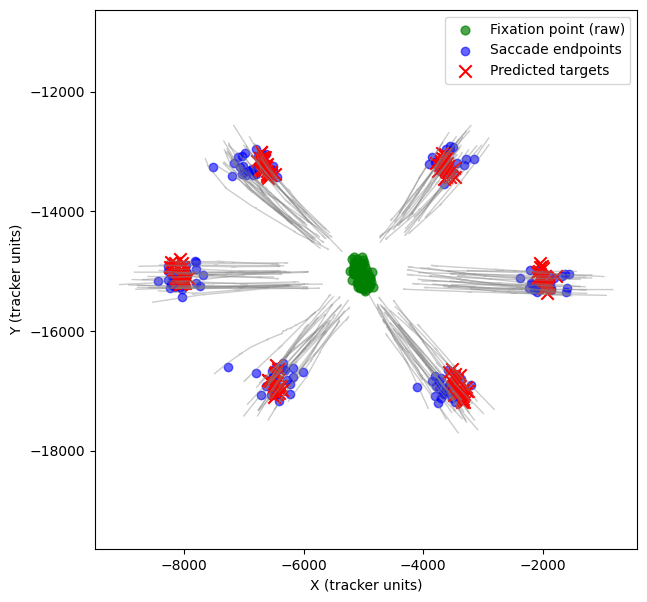

In [14]:
mask = (df_idx["correct"] == 1) & df_idx[["endX_raw","endY_raw",
                                          "targX_raw_pred","targY_raw_pred",
                                          "responseTime_idx","responseDone_idx",
                                          "fixBaseX_raw","fixBaseY_raw"]].notna().all(axis=1)

plt.figure(figsize=(7,7))

for i in df_idx[mask].index:
    # trajectory: from saccade start → end
    s = int(max(0, round(df_idx.at[i, "responseTime_idx"])))
    e = int(min(eye_sel.shape[0], round(df_idx.at[i, "responseDone_idx"])+1))
    x_traj = eye_sel[s:e, 0, i]
    y_traj = eye_sel[s:e, 1, i]
    plt.plot(x_traj, y_traj, color="gray", alpha=0.4, linewidth=1)

# Fixation baselines (green circles)
plt.scatter(df_idx.loc[mask, "fixBaseX_raw"],
            df_idx.loc[mask, "fixBaseY_raw"],
            c="green", marker="o", s=40, alpha=0.7, label="Fixation point (raw)")

# Endpoints (blue dots)
plt.scatter(df_idx.loc[mask, "endX_raw"],
            df_idx.loc[mask, "endY_raw"],
            c="blue", alpha=0.6, label="Saccade endpoints")

# Predicted targets (red crosses)
plt.scatter(df_idx.loc[mask, "targX_raw_pred"],
            df_idx.loc[mask, "targY_raw_pred"],
            c="red", marker="x", s=80, label="Predicted targets")

plt.xlabel("X (tracker units)")
plt.ylabel("Y (tracker units)")
plt.axis("equal")
plt.legend()
plt.show()


In [15]:
needed = ["correct","targX","targY","endX_raw","endY_raw","fixBaseX_raw","fixBaseY_raw"]
good = (df_idx["correct"] == 1) & df_idx[needed].notna().all(axis=1)

T = df_idx.loc[good, ["targX","targY"]].to_numpy(float)                # dva
R = df_idx.loc[good, ["endX_raw","endY_raw"]].to_numpy(float)          # raw
B = df_idx.loc[good, ["fixBaseX_raw","fixBaseY_raw"]].to_numpy(float)  # raw
R_rel = R - B

# 2x2 linear map: R_rel ≈ T @ A
A, *_ = np.linalg.lstsq(T, R_rel, rcond=None)
Ainv = np.linalg.pinv(A)  # robust inverse in case of conditioning

# ---------- (A) Response in RAW tracker units (relative to fixation) ----------
R_all = df_idx[["endX_raw","endY_raw"]].to_numpy(float)
B_all = df_idx[["fixBaseX_raw","fixBaseY_raw"]].to_numpy(float)
R_all_rel = R_all - B_all

respEcc_raw = np.hypot(R_all_rel[:,0], R_all_rel[:,1])
respAng_raw = np.rad2deg(np.arctan2(R_all_rel[:,1], R_all_rel[:,0]))
respAng_raw = (respAng_raw + 180) % 360 - 180

df_idx["respEcc_raw"] = respEcc_raw
df_idx["respAng_raw"] = respAng_raw

# ---------- (B) Response transformed to DVA (comparable to targEcc/Ang) ----------
# T_hat ≈ R_rel @ Ainv
respXY_dva = R_all_rel @ Ainv
df_idx["respX_dva"] = respXY_dva[:,0]
df_idx["respY_dva"] = respXY_dva[:,1]

df_idx["respEcc_dva"] = np.hypot(df_idx["respX_dva"], df_idx["respY_dva"])
respAng_dva = np.rad2deg(np.arctan2(df_idx["respY_dva"], df_idx["respX_dva"]))
df_idx["respAng_dva"] = (respAng_dva + 180) % 360 - 180


In [16]:
df_idx[['targEcc', 'targAng', 'respEcc_dva', 'respAng_dva']]

,targEcc,targAng,respEcc_dva,respAng_dva
0,6.0,180.0,5.587042,175.692547
1,6.0,-60.0,5.484981,-53.625953
2,6.0,0.0,5.613354,-2.751119
3,6.0,-120.0,5.762305,-119.581607
4,6.0,-60.0,6.043118,-52.937969
...,...,...,...,...
136,6.0,-60.0,6.771007,-61.390377
137,6.0,120.0,5.431025,116.387952
138,6.0,120.0,5.425095,116.620591
139,6.0,0.0,6.374213,0.733021


In [17]:
df_idx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 42 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   trial             141 non-null    int64  
 1   correct           141 non-null    int64  
 2   targetPos         141 non-null    object 
 3   trialStart        141 non-null    float64
 4   fixptOn           141 non-null    float64
 5   fixationTime      141 non-null    float64
 6   fixptOn2          141 non-null    float64
 7   stimOn            141 non-null    int64  
 8   stimOff           141 non-null    float64
 9   targetOn          141 non-null    float64
 10  targetOff         141 non-null    float64
 11  fixptOff          141 non-null    float64
 12  responseTime      141 non-null    float64
 13  responseDone      141 non-null    float64
 14  trialStart_idx    141 non-null    float64
 15  fixptOn_idx       141 non-null    float64
 16  fixationTime_idx  141 non-null    float64
 1

In [18]:
df_idx["memoryDelay"] = df_idx["responseTime"] - df_idx["targetOff"]

In [19]:
df_idx[['memoryDelay', 'targAng', 'respAng_dva']]

,memoryDelay,targAng,respAng_dva
0,0.942000,180.0,175.692547
1,0.958550,-60.0,-53.625953
2,0.875275,0.0,-2.751119
3,1.000800,-120.0,-119.581607
4,1.010825,-60.0,-52.937969
...,...,...,...
136,0.987550,-60.0,-61.390377
137,0.925400,120.0,116.387952
138,0.943675,120.0,116.620591
139,0.944450,0.0,0.733021


In [20]:
df = pd.DataFrame({
    "delay": df_idx["memoryDelay"],
    "curr": df_idx["targAng"],
    "resp": df_idx["respAng_dva"]
})

# Shift targAng by 1 to make prev (first trial will become NaN)
df["prev"] = df["curr"].shift(1)

# Circular distance (prev - curr) in degrees, wrapped to [-180, 180]
def circ_diff(a, b):
    if pd.isna(a) or pd.isna(b):
        return np.nan
    d = (a - b + 180) % 360 - 180
    return d

df["diff"] = [circ_diff(p, c) for p, c in zip(df["prev"], df["curr"])]

df["diff"] = df["diff"].abs()

def circ_err(curr, resp):
    if pd.isna(curr) or pd.isna(resp):
        return np.nan
    d = (curr - resp + 180) % 360 - 180
    return d

df["err"] = [circ_err(c, r) for c, r in zip(df["curr"], df["resp"])]


df


,delay,curr,resp,prev,diff,err
0,0.942000,180.0,175.692547,NaN,NaN,4.307453
1,0.958550,-60.0,-53.625953,180.0,120.0,-6.374047
2,0.875275,0.0,-2.751119,-60.0,60.0,2.751119
3,1.000800,-120.0,-119.581607,0.0,120.0,-0.418393
4,1.010825,-60.0,-52.937969,-120.0,60.0,-7.062031
...,...,...,...,...,...,...
136,0.987550,-60.0,-61.390377,-120.0,60.0,1.390377
137,0.925400,120.0,116.387952,-60.0,180.0,3.612048
138,0.943675,120.0,116.620591,120.0,0.0,3.379409
139,0.944450,0.0,0.733021,120.0,120.0,-0.733021


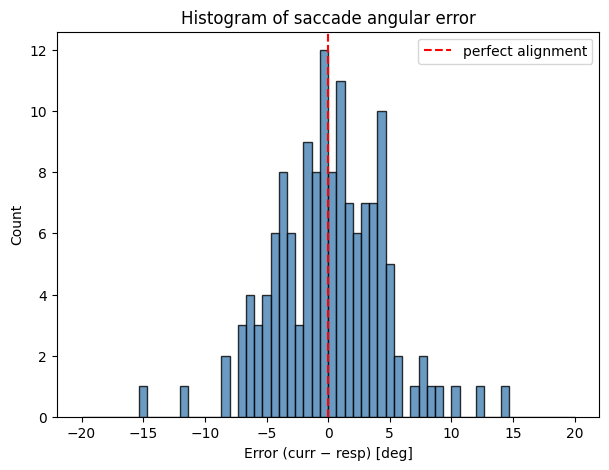

In [21]:
err = df["err"].dropna()

plt.figure(figsize=(7,5))
plt.hist(err, bins=60, range=(-20,20), color="steelblue", alpha=0.8, edgecolor="k")

plt.xlabel("Error (curr − resp) [deg]")
plt.ylabel("Count")
plt.title("Histogram of saccade angular error")
plt.axvline(0, color="red", linestyle="--", label="perfect alignment")
plt.legend()
plt.show()


Delay bins:
delay_bin
(0.752, 0.865]    18
(0.865, 0.895]    18
(0.895, 0.915]    17
(0.915, 0.93]     18
(0.93, 0.943]     17
(0.943, 0.956]    18
(0.956, 0.976]    17
(0.976, 1.095]    18
Name: count, dtype: int64
0    0.813690
1    0.881171
2    0.907018
3    0.924172
4    0.936513
5    0.948978
6    0.966046
7    1.003560
Name: delay_mean, dtype: float64


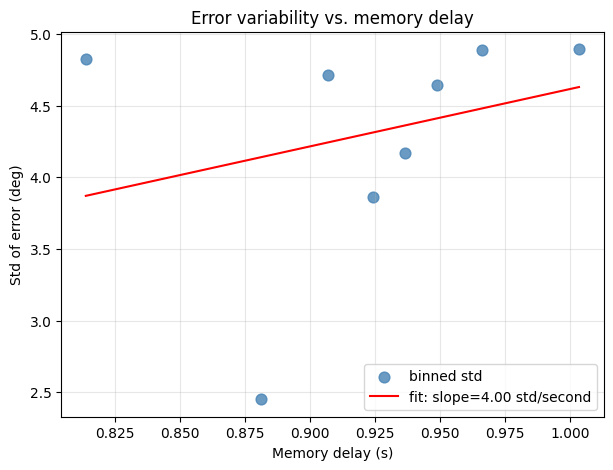

In [24]:
valid = df[["delay","err"]].dropna()

bins = 8
valid["delay_bin"] = pd.qcut(valid["delay"], q=bins, duplicates="drop")

print("Delay bins:")
print(valid["delay_bin"].value_counts().sort_index())

stats = valid.groupby("delay_bin", observed=False).agg(
    delay_mean=("delay","mean"),
    err_std=("err","std")
).reset_index()

plt.figure(figsize=(7,5))
plt.scatter(stats["delay_mean"], stats["err_std"], color="steelblue", s=60, alpha=0.8, label="binned std")

if len(stats) > 2:
    coeffs = np.polyfit(stats["delay_mean"], stats["err_std"], 1)
    print(stats["delay_mean"])
    xs = np.linspace(stats["delay_mean"].min(), stats["delay_mean"].max(), 100)
    ys = np.polyval(coeffs, xs)
    plt.plot(xs, ys, color="red", label=f"fit: slope={coeffs[0]:.2f} std/second")

plt.xlabel("Memory delay (s)")
plt.ylabel("Std of error (deg)")
plt.title("Error variability vs. memory delay")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Diff bins:
diff_bin
(-180, -150]     0
(-150, -120]     0
(-120, -90]      0
(-90, -60]       0
(-60, -30]       0
(-30, 0]        27
(0, 30]          0
(30, 60]        52
(60, 90]         0
(90, 120]       39
(120, 150]       0
(150, 180]      22
Name: count, dtype: int64
Bin Center: -165.0, Bin Range: (-180, -150], Diff Values: [], Err Values: []
Bin Center: -135.0, Bin Range: (-150, -120], Diff Values: [], Err Values: []
Bin Center: -105.0, Bin Range: (-120, -90], Diff Values: [], Err Values: []
Bin Center: -75.0, Bin Range: (-90, -60], Diff Values: [], Err Values: []
Bin Center: -45.0, Bin Range: (-60, -30], Diff Values: [], Err Values: []
Bin Center: -15.0, Bin Range: (-30, 0], Diff Values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Err Values: [0.4220220880235388, -1.6699179936017003, 0.34220672513640693, 0.8526419168046289, -1.390640100351078, 2.0029983066413024, -3.1029392576712667, 0.

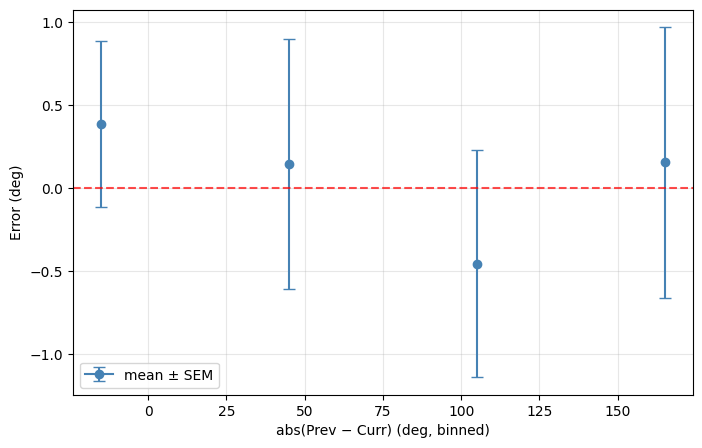

In [23]:
valid = df[["diff","err"]].dropna()

# Bin diff into 30° bins
bin_edges = np.arange(-180, 181, 30)  # edges: -180, -150, ..., 180
valid["diff_bin"] = pd.cut(valid["diff"], bins=bin_edges)
print("Diff bins:")
print(valid["diff_bin"].value_counts().sort_index())

# Compute mean ± SEM of error in each bin
stats = valid.groupby("diff_bin", observed=False)["err"].agg(["mean","count","std"])
stats["sem"] = stats["std"] / np.sqrt(stats["count"])

# Get bin centers for plotting
bin_centers = [interval.mid for interval in stats.index]
for center, interval in zip(bin_centers, stats.index):
    bin_err_values = valid.loc[valid["diff_bin"] == interval, "err"].tolist()
    bin_diff_values = valid.loc[valid["diff_bin"] == interval, "diff"].tolist()
    print(f"Bin Center: {center}, Bin Range: {interval}, Diff Values: {bin_diff_values}, Err Values: {bin_err_values}")

# Plot mean error vs diff bin
plt.figure(figsize=(8,5))
plt.errorbar(bin_centers, stats["mean"], yerr=stats["sem"], 
             fmt="o-", capsize=4, color="steelblue", label="mean ± SEM")

plt.axhline(0, color="red", linestyle="--", alpha=0.7)
plt.xlabel("abs(Prev − Curr) (deg, binned)")
plt.ylabel("Error (deg)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
